# Paavo Reinikka, 589479

# Lab exercise #1: Linear regression and Gaussian distributions

### Learning objectives

The purpose of this exercise is to become familiar with the multivariate Gaussian distribution and the basics of Bayesian inference. 


- Manipulate, implement, and sample from  multivariate Gaussian densities


- Explain the role of the prior, likelihood, posterior, and model evidence in Bayesian inference.


- Derive the posterior distribution of the regression weight for a ridge regression model. 


You are only allowed to use the numpy module to solve the exercises and **not** statistics specific modules (e.g scipy.stats or GPy)

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb
snb.set(font_scale=1.5)

### Gaussian linear regression

Linear regression is perhaps the most frequently used technique in applied statistics for modelling the relationship between set of a covariates $\left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N$ and a response variable $\left\lbrace y_n \right\rbrace_{n=1}^N$. More formally, let $\mathbf{X} \in \mathbb{R}^{N \times D}$ be a design matrix and let  $\mathbf{y} \in \mathbb{R}^N$ be the response variables, then the linear regression model is given by

\begin{align}
\mathbf{y} = \mathbf{X}\mathbf{w} + \mathbf{e},
\end{align}


where $\mathbf{w} \in \mathbb{R}^D$ is the regression weights and $\mathbf{e} \in \mathbb{R}^N$ is a noise vector.

Assuming isotropic Gaussian noise and imposing a multivariate Gaussian prior on $\mathbf{w} \sim \mathcal{N}\left(\mathbf{m}, \mathbf{S}\right)$ gives rise to the following joint distribution


\begin{align}
p(\mathbf{y}, \mathbf{w}) = p\left(\mathbf{y}|\mathbf{w}\right)p\left(\mathbf{w}\right) = \mathcal{N}\left(\mathbf{y}\big|\mathbf{Xw}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{w}\big|\mathbf{m}, \mathbf{S}\right).
\end{align}


In this exercise, we will use the following simple model as running example:


\begin{align}
y_n = ax_n + b +  e_n = \begin{bmatrix}x_n&1\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} + e_n.
\end{align}


That is, $\mathbf{w} = \left[a, b\right]$, where $a$ and $b$ are the slope and intercept of the line, respectively. Furthermore, we will assume $\mathbf{m} = \mathbf{0}$, $\mathbf{S} = 10\cdot\mathbf{I}$, and $\sigma^2 = 2$.



We will use the following data set with $N = 20$ data points

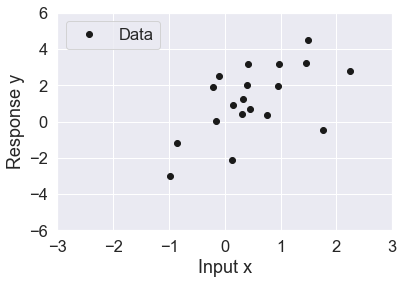

In [2]:
# hyperparameters of the prior
m = np.zeros((2, 1))
S = 10*np.identity(2)

# noise variance
sigma2 = 2

# data
N = 20
x = np.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151, -0.103, 0.411, 0.144, 1.454, 0.761, 0.122,
              0.444, 0.334, 1.494, -0.205,  0.313, -0.854])[:, None]
y = np.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009, 2.513, 3.194, 0.935, 3.216, 0.386, -2.118,
               0.674, 1.222, 4.481, 1.893, 0.422,  -1.209])[:, None]

# plot
plt.plot(x, y, 'k.', label='Data', markersize=12)
plt.xlabel('Input x')
plt.ylabel('Response y')
plt.legend()
plt.xlim((-3, 3))
plt.ylim((-6, 6));

### Task 1: The prior, likelihood and posterior

The purpose of this task is to implement the basic building blocks of the linear model. In the cells below, you are given a set of function templates and the task is to complete the implementations as specified below.

Hint: look for Rasmussen book section 2.1 (http://www.gaussianprocess.org/gpml/)

- **Task 1a**: Implement the multivariate gaussian density function using numpy (Hint: to avoid numerical problems, always add a small diagonal constant to covariance matrices)

\begin{align}
N(x | \mu, \Sigma ) = (2\pi)^{-\frac{D}{2}} | \Sigma |^{-\frac{1}{2}} \exp\left[-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu) \right]
\end{align}



In [ ]:
def mvn_pdf(x, mu, Sigma, log=True):
    """ Returns the log density of a multivariate Gaussian distribution
    with mean mu and covariace Sigma at point x
    
    Arguments:
    x     -- (Dx1) evaluation point
    mu    -- (Dx1) mean vector
    Sigma -- (DxD) covariance matrix
    log   -- (bool) if true, return log density. If false, return (default=True)
      
    Returns:
    (scalar) density
    """
    
    Sigma += 1e-8*np.eye(Sigma.shape[0])
    ret = -.5*(np.linalg.slogdet(2*np.pi*Sigma)[1] + (x-mu).T@np.linalg.inv(Sigma)@(x-mu))
    #ret = -.5*(np.log(np.linalg.det(Sigma)) + (x-mu).T@np.linalg.inv(Sigma)@(x-mu))
    if(log):
        return ret.item()
    return np.exp(ret.item())
    
    

- **Task 1b**: Implement functions to evaluate log density of the (i) prior, (ii) likelihood and (iii) posterior using the <tt>mvn_pdf</tt> function above. Hint: Use the function <tt>predict(x, a, b)</tt> given below

In [ ]:
def predict(x, a, b):
    """ returns prediction for inputs x given parameter (a,b)
    
    Arguments:
    x    --  (Nx1) vector of inputs
    a    --  slope parameter
    b    --  intercept parameter
    
    Returns:
    (Nx1) vector of predictions
    """
    return a*x + b


def log_prior(a, b):
    """ returns the log density of the prior at the points (a,b) given m and S
    
    Arguments:
    a    -- (scalar) slope parameter
    b    -- (scalar) intercept parameters
    
    Returns
    (scalar) log density for the pair (a,b)
    
    """
    return mvn_pdf(np.array([[a,b]]).T,m,S)


def log_likelihood(x, y, a, b):
    """ returns the log likelihood for the data (x,y) given the parameters (a,b)
    
    Arguments:
    x    -- (Nx1) vector of inputs
    y    -- (Nx1) vector of responses
    a    --  slope parameter
    b    --  intercept parameter
    
    Returns:
    (scalar) log likelihood of (x,y) 
    """
    
    return mvn_pdf(y,predict(x,a,b),sigma2*np.eye(y.shape[0]))


def log_posterior(x, y, a, b):
    """ returns the log posterior for the data (x,y) given the parameters (a,b)
    
    Arguments:
    x    -- (Nx1) vector of inputs
    y    -- (Nx1) vector of responses
    a    --  slope parameter
    b    --  intercept parameter
    
    Returns:
    (scalar) log posterior of (x,y)
    """
        
    #NOTE: I am using un-scaled log-posterior, since it's sufficient for density-/contourplots.
    # The only difference would be an addition of the normalization term (scaling for non-log-posterior).
    # Alternatively, I could have calculated the full posterior, but then it would seem redundant to compare
    # with the result in part 2.
    return log_prior(a,b) + log_likelihood(x,y,a,b)



- **Task 1c**: The goal of this task is to make contour plots of the prior density, the likelihood and the posterior as a function of (a,b) in the intervals $-6 \leq a \leq 6$ and $-6 \leq b \leq 6$, respectively, by completing the implementation of the functions: <tt>plot_prior_density</tt>,  <tt>plot_likelihood</tt>,  <tt>plot_posterior_density</tt> given below. 

Hint: Check the numpy function <tt>meshgrid</tt> and pyplot function <tt>contour</tt> to plot 2D densities.

**NOTE: I am using contourf, since it seems to better show the shapes, compared to simple contourlines.**

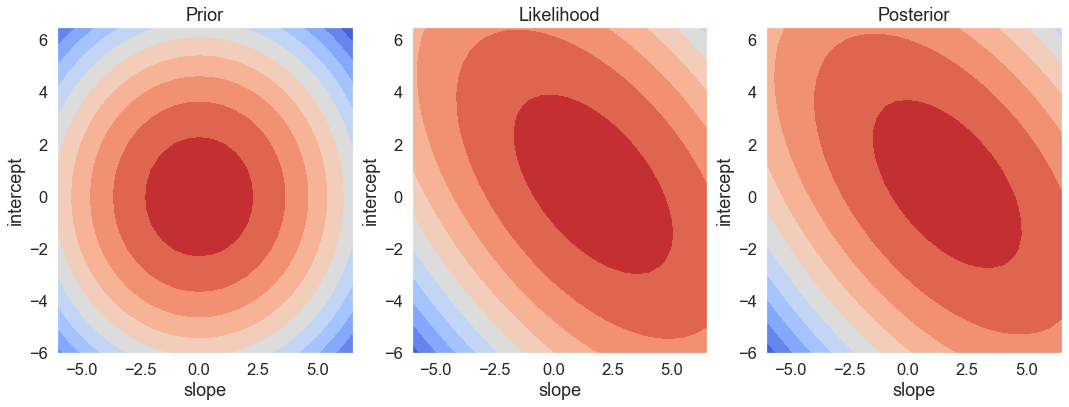

In [ ]:

def plot_prior_density():
    
    xx,yy = np.meshgrid(np.arange(-6,7,.5),np.arange(-6,7,.5))
    zz = np.vectorize(log_prior)(xx,yy)
    
    plt.contourf(xx,yy,zz,10, cmap='coolwarm')#, colors='black')
    plt.xlabel('slope')
    plt.ylabel('intercept');
    
def plot_likelihood(x, y):
    
    xx,yy = np.meshgrid(np.arange(-6,7,.5),np.arange(-6,7,.5))
    foo = lambda aa,bb: log_likelihood(x,y,aa,bb)
    zz = np.vectorize(foo)(xx,yy)
    
    plt.contourf(xx,yy,zz,10, cmap='coolwarm')#, colors='black')
    
    plt.xlabel('slope')
    plt.ylabel('intercept');

def plot_posterior_density(x, y):

    xx,yy = np.meshgrid(np.arange(-6,7,.5),np.arange(-6,7,.5))
    foo = lambda aa,bb: log_posterior(x,y,aa,bb)
    zz = np.vectorize(foo)(xx,yy)
    
    plt.contourf(xx,yy,zz,10, cmap='coolwarm')#, colors='black')
    plt.xlabel('slope')
    plt.ylabel('intercept');

    
# plot
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plot_prior_density()
plt.title('Prior')

plt.subplot(1, 3, 2)
plot_likelihood(x, y)
plt.title('Likelihood')

plt.subplot(1, 3, 3)
plot_posterior_density(x, y)
plt.title('Posterior');

The prior has such a high variance, that it allows the data (i.e., likelihood) to dominate.

### Task 2: Analytical expression of the posterior distribution

- **Task 2a**: Show that the posterior is given by $p(\mathbf{w}\big|\mathbf{y}) = \mathcal{N}\left(\mathbf{w}\big|\mu, \Sigma\right)$, where


\begin{align}
\Sigma &= \left(\frac{1}{\sigma^2}\mathbf{X}^T\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}\\
\mu &= \Sigma\left(\frac{1}{\sigma^2}\mathbf{X}^T\mathbf{y} + \mathbf{S}^{-1}\mathbf{m}\right)
\end{align}

Hints:
1. Use Bayes rule to obtain an expression for the posterior $p(\mathbf{w}\big|\mathbf{y})$ in terms of the prior, likehood and marginal likelihood
2. Take the logarithm on both sides and expand the right hand side
3. Conclude that only a subset of the terms depends on $\mathbf{w}$. Replace all terms independent of $\mathbf{w}$ with a constant
4. Argue that the posterior distribution must be Gaussian as the remaining terms on the right hand side is a quadratic function of $\mathbf{w}$. 
5. Determine the posterior mean and covariance by 'completing the square' or by comparing the coefficients of the quadractic functions to the logarithm of a multivariate Guassian distribution with mean $\mu$ and covariance $\Sigma$.

For background see Rasmussen section 2.1.1.



**NOTE: In my solution, I will use "completing the square", i.e.:**

$$
    -\dfrac{1}{2}\mathbf{w}^\top \mathbf{A}\mathbf{w} + \mathbf{b}^\top \mathbf{w}
    = -\dfrac{1}{2}(\mathbf{w}-\mathbf{A}^{-1}\mathbf{b})^\top \mathbf{A} 
    (\mathbf{w}-\mathbf{A}^{-1}\mathbf{b})
    + \dfrac{1}{2}\mathbf{b}^\top \mathbf{A}^{-1}\mathbf{b}\\
    =-\dfrac{1}{2}(\mathbf{w}-\mathbf{A}^{-1}\mathbf{b})^\top \mathbf{A} 
    (\mathbf{w}-\mathbf{A}^{-1}\mathbf{b}) + const
$$

**which basically means I will solve terms $\mathbf{A},\mathbf{b}$. In this form, I can easily recognize the "Gaussianity", and drop the constant terms. I will (unseremoniously = without further comments) drop the terms independent of parameters of interest, and only concentrate on the quadratic form with parameters $\mathbf{w}$. Instead of dragging/developing a "const" -term, I use the $\propto$ symbol to cover the issue.** 

### SOLUTION:

$$
p(\mathbf{w}\mid \mathbf{y})\propto p(\mathbf{y}\mid\mathbf{w})p(\mathbf{w})
$$

where:

$$
p(\mathbf{w})=\dfrac{1}{\sqrt{\det(2\pi\Sigma)}} \exp{\Big[-\dfrac{1}{2}(
\mathbf{w}-\mathbf{m})^\top \mathbf{S}^{-1}(
\mathbf{w}-\mathbf{m})
\Big]}
$$

and
$$
p(\mathbf{y}\mid\mathbf{w})=\dfrac{1}{\sqrt{\det(2\pi\sigma_n^2I)}}
\exp{\Big[-\dfrac{1}{2\sigma_n^2}(
\mathbf{y}-\mathbf{Xw})^\top(
\mathbf{y}-\mathbf{Xw})\Big]}
$$

So, we get:

$$
p(\mathbf{w}\mid \mathbf{y})\propto
\exp{\Big[-\dfrac{1}{2\sigma_n^2}(
\mathbf{y}-\mathbf{Xw})^\top(
\mathbf{y}-\mathbf{Xw})
-\dfrac{1}{2}(
\mathbf{w}-\mathbf{m})^\top \mathbf{S}^{-1}(
\mathbf{w}-\mathbf{m})
\Big]}
$$

And, focusing on the exponential:

$$
p(\mathbf{w}\mid \mathbf{y})\propto
\exp{
\Big[
-\dfrac{1}{2\sigma_n^2}(||\mathbf{y}||^2 - 2\mathbf{y}^\top\mathbf{Xw}+\mathbf{w^\top X^\top Xw})
-\dfrac{1}{2}(\mathbf{w^\top S^{-1}w-2m^\top S^{-1}w + m^\top S^{-1}m})
\Big]
}\\
\propto \exp{
\Big[
-\dfrac{1}{2\sigma_n^2}\mathbf{w^\top X^\top Xw}-\dfrac{1}{2}\mathbf{w^\top S^{-1}w}
+\dfrac{1}{\sigma_n^2}\mathbf{y^\top Xw + m^\top S^{-1}w}
\Big]
}\\
= \exp{
\Big[
-\dfrac{1}{2}\mathbf{w^\top} (\dfrac{1}{\sigma_n^2}\mathbf{X^\top X} + \mathbf{S^{-1}})\mathbf{w}
+(\dfrac{1}{\sigma_n^2}\mathbf{y^\top X + m^\top S^{-1}})\mathbf{w}
\Big]
}\\
= \exp{
\Big[
-\dfrac{1}{2}\mathbf{w^\top} \mathbf{Aw}
+\mathbf{b^\top w}
\Big]
}
$$

From here we can recognize the terms $\mathbf{A,b}$:

$$
\mathbf{A}=\dfrac{1}{\sigma_n^2}\mathbf{X^\top X} + \mathbf{S^{-1}}\\
\mathbf{b^\top}=\dfrac{1}{\sigma_n^2}\mathbf{y^\top X + m^\top S^{-1}}\\
\implies \mathbf{b}=\dfrac{1}{\sigma_n^2}\mathbf{X^\top y + S^{-1}m}
$$

Finally, completing the square:

$$
\exp{
\Big[
-\dfrac{1}{2}\mathbf{w^\top} \mathbf{Aw}
+\mathbf{b^\top w}
\Big]
}
=\exp{
\Big[-\dfrac{1}{2}(\mathbf{w}-\mathbf{A}^{-1}\mathbf{b})^\top \mathbf{A} 
    (\mathbf{w}-\mathbf{A}^{-1}\mathbf{b})
    + \dfrac{1}{2}\mathbf{b}^\top \mathbf{A}^{-1}\mathbf{b}
    \Big]
}\\
\propto \exp{
\Big[-\dfrac{1}{2}(\mathbf{w}-\mathbf{A}^{-1}\mathbf{b})^\top \mathbf{A} 
    (\mathbf{w}-\mathbf{A}^{-1}\mathbf{b})
    \Big]}
$$

And from here we can recognize the posterior covariance $\Sigma=\mathbf{A}^{-1}$ and posterior mean $\mu = \mathbf{A^{-1}b}$ (note: the second term was not depend on the parameters, therefore constituting only a constant term, and the first term was/is in the standard quadratic form of a Gaussian):

$$
\Sigma = \mathbf{A}^{-1} = (\dfrac{1}{\sigma_n^2}\mathbf{X^\top X} + \mathbf{S}^{-1})^{-1}\\
\mu = \mathbf{A^{-1}b} = \Sigma (\dfrac{1}{\sigma_n^2}\mathbf{X^\top y + S^{-1}m})
$$

This should cover the proof. Furthermore, one could note that normal prior is conjugate to normal likelihood, which guarantees that also the posterior is normal.

- **Task 2b**: Complete the implementation of the function for computing the analytical posterior distribution given below. Hint: The function <tt>design_matrix</tt> maps from a vectors of input $\mathbf{x}$ to the design matrix $\mathbf{X}$.

In [ ]:
def design_matrix(x):
    """ returns the design matrix for a vector of input values x 
    
    Arguments:
    x    -- (Nx1) vector of inputs
    
    Returns:
    (Nx2) design matrix
    
    """
    X = np.column_stack((x, np.ones(len(x))))
    return X

def compute_posterior(x, y, m, S, sigma2):
    """ return the posterior mean and covariance of w given (x,y) 
    and hyperparameters m, S and sigma2
    
    Arguments:
    x      -- (Nx1) vector of inputs
    y      -- (Nx1) vector of responses
    m      -- (Dx1) prior mean
    S      -- (DxD) prior covariance
    sigma2 -- (scalar) noise variance
    
    Returns:
    mu     -- (Dx1) posterior mean
    Sigma  -- (DxD) posterior covariance
    
    """
    
    X = design_matrix(x)
    S += 1e-8*np.eye(S.shape[0])
    Sinv = np.linalg.inv(S)
    Sigma = np.linalg.inv(1./sigma2*X.T@X + Sinv)
    mu = Sigma@(1./sigma2*X.T@y + Sinv@m)
    return mu, Sigma
    

- **Task 2c**: Using the function above, compute the posterior mean and covariance for the data set $(\mathbf{x}, \mathbf{y})$. Plot the resulting density and check that it matches the posterior distribution from task 1d.

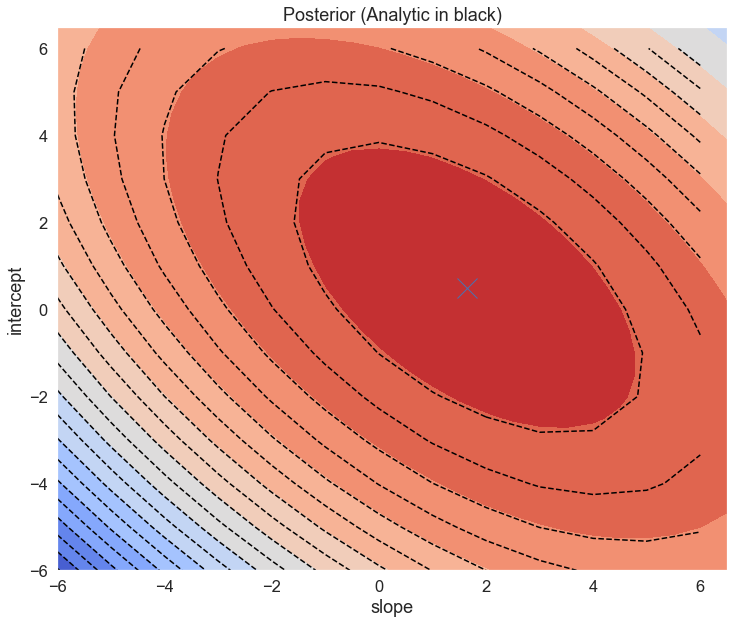

In [ ]:
mu_pos, Sigma_pos = compute_posterior(x,y,m,S,sigma2)

def plot_analytic_posterior(mu_pos,Sigma_pos):
    xx,yy = np.meshgrid(np.arange(-6,7),np.arange(-6,7))
    foo = lambda aa,bb: mvn_pdf(np.array([aa,bb])[:,None],mu_pos,Sigma_pos)
    zz = np.vectorize(foo)(xx,yy)
    
    plt.contour(xx,yy,zz,20, colors='black')
    
plt.figure(figsize=(12,10))
plot_analytic_posterior(mu_pos, Sigma_pos)

plot_posterior_density(x, y)
plt.title('Posterior (Analytic in black)');

plt.plot(mu_pos[0], mu_pos[1], marker='x', markersize=20)
plt.show()

Clearly, the analytic solution (black dashed line) agrees with the log_posterior -function.

### Task 3: Combining all of the above

In this task, you will use all the functions you implemented above to perform compute the posterior distribution $p\left(\mathbf{w}|\mathbf{y}\right)$ for various sizes of $N$. The cell below analyses the data set using $N = \left\lbrace 1, 2, 10, 20 \right\rbrace$ data points, where the columns visualise (i) data and sample functions, (ii) the prior, (iii) the likelihood and (iv) posterior. 

- **Task 3a**: The code below is complete, and works without issues if you have implemented all previous tasks. Make sure the code works and you can see the four visualisations.

- **Task 3b**: Study the code and plots and explain what you see. How does the blue lines in the first column relate to the blue dots in the fourth column? What happens as the number of samples increase? Why does the prior have so little effect in the last row?


### Answers for 3b (I also wrote some comments along the code):

**i)** The relation between 1st and 4th column: Each blue line is a linear function, whose parameters are drawn from the (parameter-)posterior - the draws are the blue dots in the fourth column. The solid red line shows the function mean (posterior), and the red dashed lines (2 std) confidence interval.

**ii)** As the number of samples increase, our posterior becomes more confident (smaller variance), and the posterior draws are more centered. By the last row, we have enough data for the likelihood to dominate; With many datapoints, the contribution of the prior to the log-posterior becomes insignificant. However, if we were to, for example, change our prior variance from 10 to 0.1 (i.e., our prior was more confident), the prior would have a greater effect even at the last row (this is easy to test). With variance 10, there is still significant density overlap with the likelihood.


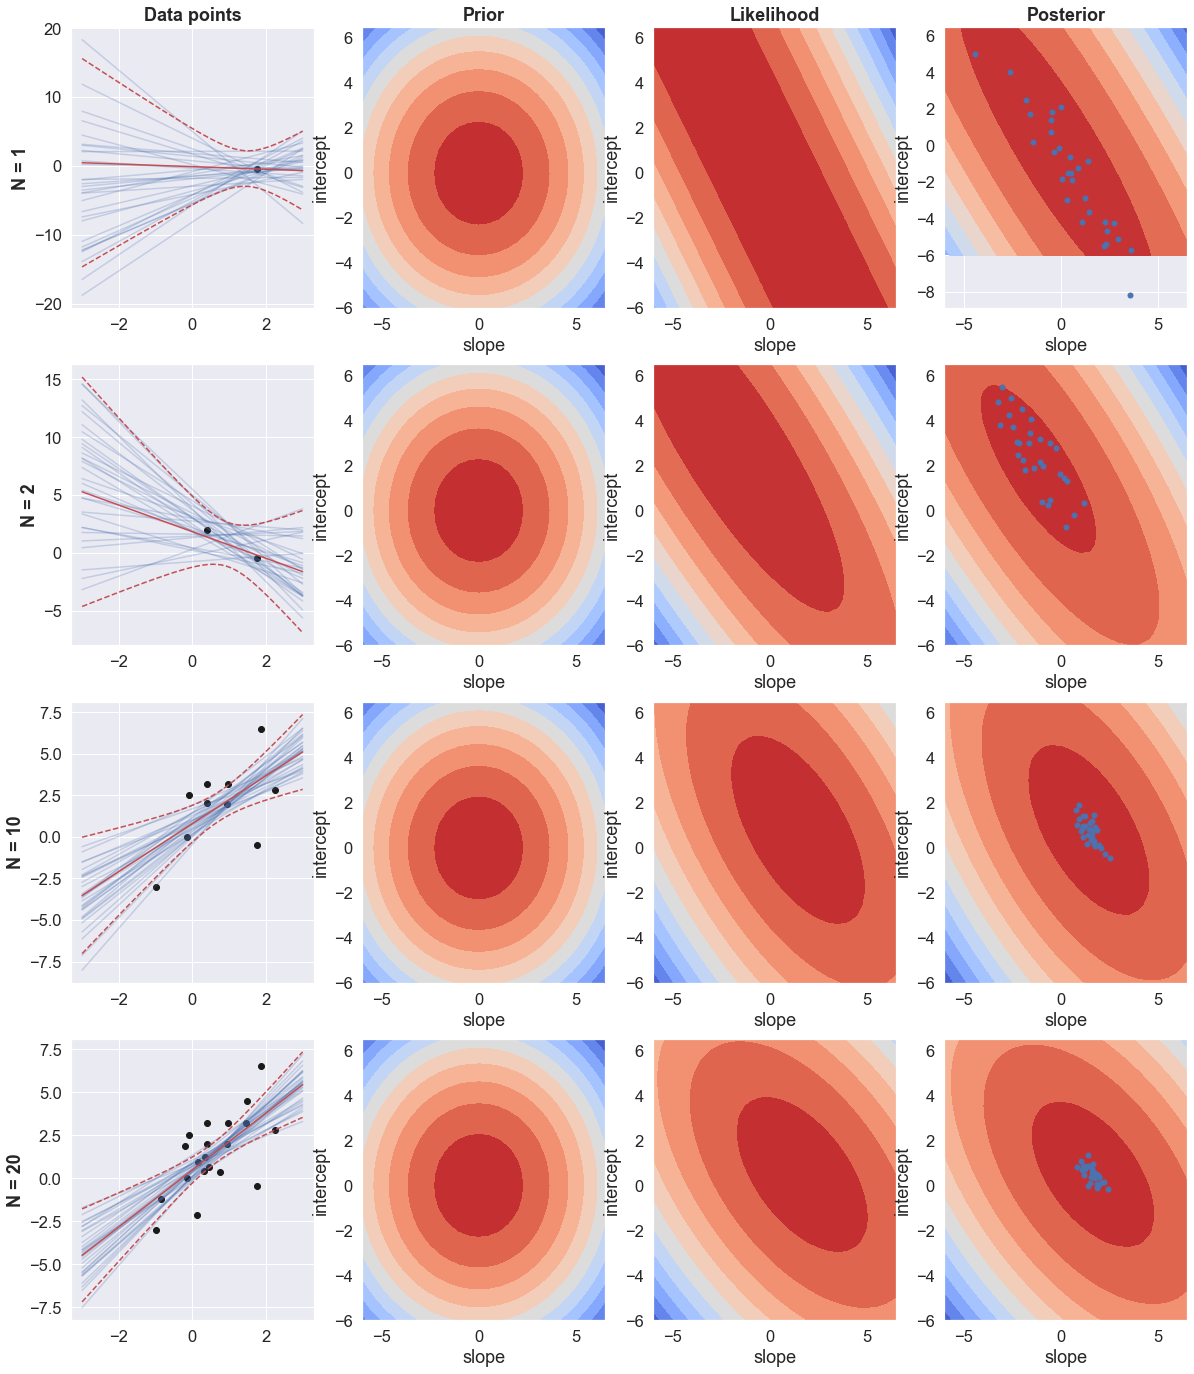

In [8]:
def generate_mvn_samples(mu, Sigma, M):
    """ return samples from a multivariate normal distribution N(mu, Sigma)

    Arguments:
    mu      -- (Dx1) mean vector
    Sigma   -- (DxD) covariance matrix
    M       -- (scalar) number of samples
    
    Returns:
    (DxM) matrix, where each column corresponds to a sample
    """
    
    jitter = 1e-8
    D = len(mu)
    L = np.linalg.cholesky(Sigma + jitter*np.identity(D))
    zs = np.random.normal(0, 1, size=(D, M)) # samples standard Gaussian, and...
    fs = mu + np.dot(L, zs) # mean shifts by mu and scales/rotates with Chol
    return fs

def compute_f_posterior(x, mu, Sigma):
    """ compute the posterior distribution of f(x) wrt. posterior distribution N(mu, Sigma) 
    
    Arguments:
    x      -- (Nx1) vector of inputs
    mu     -- (2x1) mean vector
    Sigma  -- (2x2) covariance matrix
    
    Returns:
    mu_f   -- (Nx1) vector of pointwise posterior means at x
    var_f  -- (Nx1) vector of pointwise posterior variances at x
    
    """
    
    #The function posterior is simply N(X@mu, X@Sigma@X.T), as a consiquence of the basic rules with Gaussians.
    X = np.column_stack((x, np.ones(len(x))))
    mu_f = np.dot(X, mu)
    var_f = np.diag(np.dot(np.dot(X, Sigma), X.T))[:, None]
        
    return mu_f, var_f


np.random.seed(0)

xp = np.linspace(-3, 3, 50)[:, None]

plt.figure(figsize=(20, 30))    
for idx_n, n in enumerate([1, 2, 10, 20]):  #IDX_N IS JUST FOR (ROW-)INDEXING PLOTS, N FOR HOW MANY DATAPOINTS
    
    # compute posterior & generate samples
    mu, Sigma = compute_posterior(x[:n, :], y[:n, :], m, S, sigma2)
    ahat, bhat = generate_mvn_samples(mu, Sigma, M=30)
  
    # plot
    plt.subplot2grid((5, 4), (idx_n, 0))
    plt.plot(x[:n, :], y[:n, :], 'k.', markersize=12)
    plt.ylabel('N = %d' % n, fontweight='bold')    
    for (ai, bi) in zip(ahat, bhat):
        plt.plot(xp, predict(xp, ai, bi), 'b-', alpha=0.25)   #PLOT POSTERIOR FUNCTIONS (BLUE LINES, 1ST COL)
        
    mu_f, var_f = compute_f_posterior(xp, mu, Sigma)
    std_f = np.sqrt(var_f)

    plt.plot(xp, mu_f, 'r') #POSTERIOR FUNCTION MEAN (RED)
    plt.plot(xp, mu_f + 2*std_f, 'r--') # 2 STANDARD DEV CONFIDENCE (RED DASHED)
    plt.plot(xp, mu_f - 2*std_f, 'r--') # SAME
    
    if idx_n == 0:
        plt.title('Data points', fontweight='bold')
        
    plt.subplot2grid((5, 4), (idx_n, 1))
    plot_prior_density()
    
    if idx_n == 0:
        plt.title('Prior', fontweight='bold')

    plt.subplot2grid((5, 4), (idx_n, 2))
    plot_likelihood(x[:n, :], y[:n, :])
       
    if idx_n == 0:
        plt.title('Likelihood', fontweight='bold')
    
    
    plt.subplot2grid((5, 4), (idx_n, 3))
    plot_posterior_density(x[:n, :], y[:n, :])
    plt.plot(ahat, bhat, 'b.', markersize=10) #PLOT PARAMETER POSTERIOR DRAWS (BLUE DOTS, 4TH COL)
        
    
    if idx_n == 0:
        plt.title('Posterior', fontweight='bold')
